# Assignment 3
In this assignment, we will implement a simplified version of object detection process.

Also, I'd like to acknowledge the Stanford CS131. This assignment is highly based on the assignments from that course.

In [ ]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, data, color, exposure, feature
from skimage.feature import hog
from skimage.filters import gaussian
from scipy.ndimage import interpolation
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time
import math

import warnings
warnings.filterwarnings('ignore')

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
# Download necessary images and unzip them
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1gDc1lzuizhHBMR1bvHmXzl3HCxyv_BDU' -O od.zip && unzip od.zip

--2021-06-28 09:27:54--  https://drive.google.com/uc?export=download&id=1gDc1lzuizhHBMR1bvHmXzl3HCxyv_BDU
Resolving drive.google.com (drive.google.com)... 108.177.96.113, 108.177.96.139, 108.177.96.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.96.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qqr1pgbc2blhrq0us39b05aoq60jn5do/1624872450000/04345933395257689425/*/1gDc1lzuizhHBMR1bvHmXzl3HCxyv_BDU?e=download [following]
--2021-06-28 09:27:57--  https://doc-10-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qqr1pgbc2blhrq0us39b05aoq60jn5do/1624872450000/04345933395257689425/*/1gDc1lzuizhHBMR1bvHmXzl3HCxyv_BDU?e=download
Resolving doc-10-1o-docs.googleusercontent.com (doc-10-1o-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-10-1o-docs.googleusercontent.com (doc-1

In [ ]:
from visualization import *

## Part 1: Hog Representation (10 points)

In this section, we will compute the average hog representation of human faces.<br>
There are 31 aligned face images provided in the `\face` folder. They are all aligned and have the same size. We will get an average face from these images and compute a hog feature representation for the averaged face. <br>
Use the hog function provided by skimage library, and implement a hog representation of objects.
Implement **`hog_feature`** 

In [ ]:
def hog_feature(image, pixel_per_cell = 8):
    """
    Compute hog feature for a given image.
    Hint: use the hog function provided by skimage.
    Args:
        image: an image with object that we want to detect.
        pixel_per_cell: number of pixels in each cell, an argument for hog descriptor.
    Returns:
        score: a vector of hog representation.
        hogImage: an image representation of hog provided by skimage.
    """
    ### YOUR CODE HERE
    hogFeature, hogImage = feature.hog(
        image, 
        pixels_per_cell=(pixel_per_cell, pixel_per_cell),
        visualize=True
    )
    ### END YOUR CODE
    return (hogFeature, hogImage)

In [ ]:
#### UTIL FUNCTION ####
def load_faces(image_paths, n):
    face_shape = io.imread('./face/' + image_paths[0], as_gray=True).shape
    avg_face = np.zeros((face_shape))
    for image_path in image_paths:
        image = io.imread('./face/'+image_path, as_gray=True)
        avg_face = np.asarray(image)+np.asarray(avg_face)
    avg_face = avg_face / n
    return face_shape, avg_face

3343.761955427906


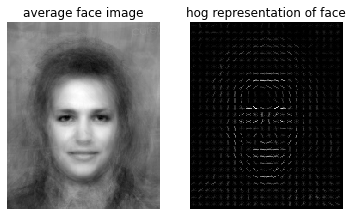

In [ ]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')
list.sort(image_paths)
n = len(image_paths)
face_shape, avg_face = load_faces(image_paths, n)

(face_feature, hog_image) = hog_feature(avg_face)

print(np.sum(face_feature))
#assert np.abs(np.sum(face_feature) - 499.970465079) < 1e-2

plot_part1(avg_face, hog_image)

# Part 2: Sliding Window (30 points)
Implement **`sliding_window`** function to have windows slide across an image with a specific window size. The window slides through the image and check if an object is detected with a high score at every location. These scores will generate a response map and you will be able to find the location of the window with the highest hog score. 

In [ ]:
def sliding_window(image, base_score, stepSize, windowSize, pixel_per_cell=8):
    """ A sliding window that checks each different location in the image,
        and finds which location has the highest hog score. The hog score is computed
        as the dot product between the hog feature of the sliding window and the hog feature
        of the template. It generates a response map where each location of the
        response map is a corresponding score. And you will need to resize the response map
        so that it has the same shape as the image.
    Hint: use the resize function provided by skimage.
    Args:
        image: an np array of size (h,w).
        base_score: hog representation of the object you want to find, an array of size (m,).
        stepSize: an int of the step size to move the window.
        windowSize: a pair of ints that is the height and width of the window.
    Returns:
        max_score: float of the highest hog score.
        maxr: int of row where the max_score is found (top-left of window).
        maxc: int of column where the max_score is found (top-left of window).
        response_map: an np array of size (h,w).
    """
    # slide a window across the image
    (max_score, maxr, maxc) = (0, 0, 0)
    winH, winW = windowSize
    H, W = image.shape
    pad_image = np.lib.pad(
        image,
        ((winH // 2,
          winH - winH // 2),
         (winW // 2,
          winW - winW // 2)),
        mode='constant')
    response_map = np.zeros((H // stepSize + 1, W // stepSize + 1))
    ### YOUR CODE HERE
    for i in range(0, H + 1, stepSize):
      for j in range(0, W + 1, stepSize):
          score = feature.hog(
              pad_image[i:i + winH, j:j + winW],
              pixels_per_cell=(pixel_per_cell, pixel_per_cell)
          ).dot(base_score)
          response_map[i // stepSize, j // stepSize] = score
          if score > max_score:
              max_score, maxr, maxc = score, i, j
    maxr, maxc = maxr - winH // 2, maxc - winW // 2
    response_map = resize(response_map, (H, W))
    ### END YOUR CODE

    return (max_score, maxr, maxc, response_map)

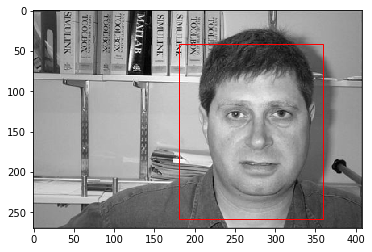

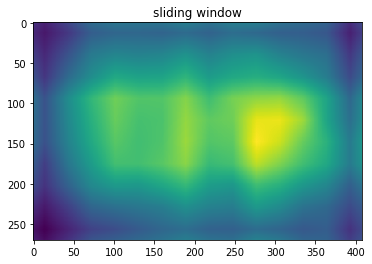

In [ ]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 0.8)

(hogFeature, hogImage) = hog_feature(image)

(winH, winW) = face_shape
(score, r, c, response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)
crop = image[r:r+winH, c:c+winW]

plot_part2(image, r, c, response_map, winW, winH)

Sliding window successfully found the human face in the above example. However, in the cell below, we are only changing the scale of the image, and you can see that sliding window does not work once the scale of the image is changed. 

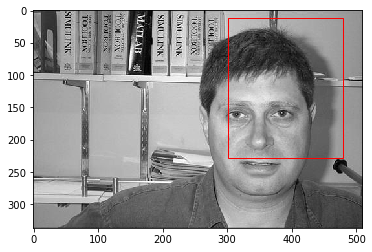

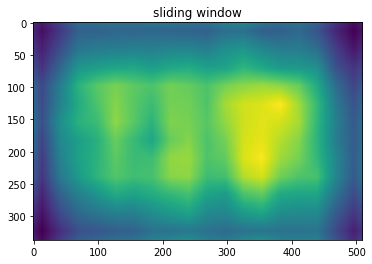

In [ ]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape
(score, r, c, max_response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)

crop = image[r:r+winH, c:c+winW]

plot_part2(image, r, c, max_response_map, winW, winH)

# Part 3: Image Pyramids (25 points)
In order to make sliding window work for different scales of images, you need to implement image pyramids where you resize the image to different scales and run the sliding window method on each resized image. This way you scale the objects and can detect both small and large objects. 

###  3.1 Image Pyramid (10 points)

Implement **`pyramid`** function, this will create pyramid of images at different scales. Run the following code, and you will see the shape of the original image gets smaller until it reaches a minimum size.


In [ ]:
def pyramid(image, scale=0.9, minSize=(200, 100)):
    """
    Generate image pyramid using the given image and scale.
    Reducing the size of the image until one of the height or
    width reaches the minimum limit. In the ith iteration,
    the image is resized to scale^i of the original image.
    Hint: use the rescale function provided by skimage.
    Args:
        image: np array of (h,w), an image to scale.
        scale: float of how much to rescale the image each time.
        minSize: pair of ints showing the minimum height and width.
    Returns:
        images: a list containing pair of
            (the current scale of the image, resized image).
    """
    # yield the original image
    images = []
    current_scale = 1.0
    images.append((current_scale, image))
    # keep looping over the pyramid
    ### YOUR CODE HERE
    minH, minW = minSize
    while image.shape[0] * scale > minH and image.shape[1] * scale > minW:
        current_scale *= scale
        image = rescale(image, scale)
        images.append((current_scale, image))
    ### END YOUR CODE
    return images

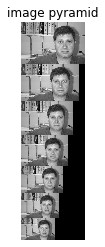

In [ ]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

images = pyramid(image, scale = 0.9)

plot_part3_1(images)

###  3.2 Pyramid Score (15 points)

After getting the image pyramid, we will run sliding window on all the images to find a place that gets the highest score. Implement **`pyramid_score`** function in. It will return the highest score and its related information in the image pyramids.

In [ ]:
def pyramid_score(image,base_score, shape, stepSize=20, scale = 0.9, pixel_per_cell = 8):
    """
    Calculate the maximum score found in the image pyramid using sliding window.
    Args:
        image: np array of (h,w).
        base_score: the hog representation of the object you want to detect.
        shape: shape of window you want to use for the sliding_window.
    Returns:
        max_score: float of the highest hog score.
        maxr: int of row where the max_score is found.
        maxc: int of column where the max_score is found.
        max_scale: float of scale when the max_score is found.
        max_response_map: np array of the response map when max_score is found.
    """
    max_score = 0
    maxr = 0
    maxc = 0
    max_scale = 1.0
    max_response_map =np.zeros(image.shape)
    images = pyramid(image, scale)
    ### YOUR CODE HERE
    for s, image in images:
        score, r, c, response_map = sliding_window(image, base_score, stepSize, shape, pixel_per_cell)
        if score > max_score:
            max_score, maxr, maxc, max_scale, max_response_map = score, r, c, s, response_map
    ### END YOUR CODE
    return max_score, maxr, maxc, max_scale, max_response_map

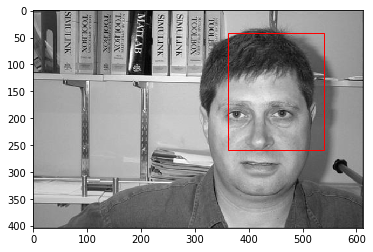

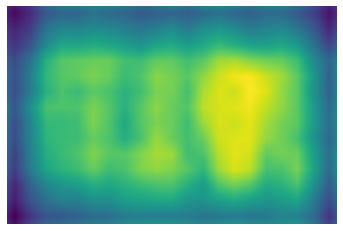

In [ ]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
max_score, maxr, maxc, max_scale, max_response_map = pyramid_score(image, face_feature, face_shape, stepSize = 30, scale=0.8)

plot_part3_2(image, max_scale, winW, winH, maxc, maxr, max_response_map)

From the above example, we can see that image pyramid has fixed the problem of scaling. Then in the example below, we will try another image and implement a deformable parts model.

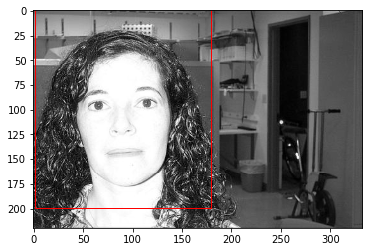

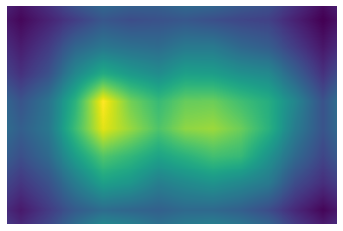

In [ ]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score(image, face_feature, face_shape, stepSize = 30, scale=0.8)

plot_part3_2(image, max_scale, winW, winH, maxc, maxr, max_response_map)

# Part 4: Deformable Parts Detection
In order to solve the problem above, you will implement deformable parts model in this section, and apply it on human faces. <br>
The first step is to get a detector for each part of the face, including left eye, right eye, nose and mouth. <br>
For example for the left eye, we have provided the groundtruth location of left eyes for each image in the `\face` directory. This is stored in the `lefteyes` array with shape `(n,2)`, each row is the `(r,c)` location of the center of left eye. You will then find the average hog representation of the left eyes in the images.

In [ ]:
#### UTIL FUNCTIONS ####
def read_facial_labels(image_paths):
    label_path = "list_landmarks_align_celeba.txt"
    n_images = len(image_paths)
    f = open(label_path, "r")
    f.readline()
    f.readline()
    lefteyes = np.array([], dtype=np.int).reshape(0, 2)
    righteyes = np.array([], dtype=np.int).reshape(0, 2)
    noses = np.array([], dtype=np.int).reshape(0, 2)
    mouths = np.array([], dtype=np.int).reshape(0, 2)
    for line in f:
        if lefteyes.shape[0] > 40:
            break
        parts = line.strip().split(' ')
        parts = list(filter(None, parts))
        #print(line,parts)
        image_file = parts[0]
        if image_file in image_paths:
            lefteye_c = int(parts[1])
            lefteye_r = int(parts[2])
            righteye_c = int(parts[3])
            righteye_r = int(parts[4])
            nose_c = int(parts[5])
            nose_r = int(parts[6])
            leftmouth_c = int(parts[7])
            leftmouth_r = int(parts[8])
            rightmouth_c = int(parts[9])
            rightmouth_r = int(parts[10])
            mouth_c = int((leftmouth_c + rightmouth_c) / 2)
            mouth_r = int((leftmouth_r + rightmouth_r) / 2)

            lefteyes = np.vstack(
                (lefteyes, np.asarray([lefteye_r, lefteye_c])))
            righteyes = np.vstack(
                (righteyes, np.asarray([righteye_r, righteye_c])))
            noses = np.vstack((noses, np.asarray([nose_r, nose_c])))
            mouths = np.vstack((mouths, np.asarray([mouth_r, mouth_c])))
    parts = (lefteyes, righteyes, noses, mouths)
    return parts

def get_detector(part_h, part_w, parts, image_paths):
    n = len(image_paths)
    part_shape = (part_h, part_w)
    avg_part = np.zeros((part_shape))
    image_paths = sorted(image_paths)
    for i, image_path in enumerate(image_paths):
        image = io.imread('./face/' + image_path, as_gray=True)
        part_r = parts[i][0]
        part_c = parts[i][1]
#         print(image_path, part_r, part_w, part_r-part_h/2, part_r+part_h/2)
        part_image = image[int(part_r - part_h / 2):int(part_r + part_h / 2),
                           int(part_c - part_w / 2):int(part_c + part_w / 2)]
        avg_part = np.asarray(part_image) + np.asarray(avg_part)
    avg_part = avg_part / n
    return avg_part

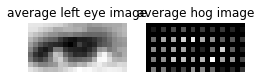

In [ ]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')

parts = read_facial_labels(image_paths)
lefteyes, righteyes, noses, mouths = parts

# Typical shape for left eye
lefteye_h = 10
lefteye_w = 20

lefteye_shape = (lefteye_h, lefteye_w)

avg_lefteye = get_detector(lefteye_h, lefteye_w, lefteyes, image_paths)
(lefteye_feature, lefteye_hog) = hog_feature(avg_lefteye, pixel_per_cell=2)

plot_part4(avg_lefteye, lefteye_hog, 'left eye')

Run through the following code to get a detector for right eye.

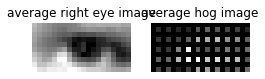

In [ ]:
righteye_h = 10
righteye_w = 20

righteye_shape = (righteye_h, righteye_w)

avg_righteye = get_detector(righteye_h, righteye_w, righteyes, image_paths)

(righteye_feature, righteye_hog) = hog_feature(avg_righteye, pixel_per_cell=2)

plot_part4(avg_righteye, righteye_hog, 'right eye')

Run through the following code to get a detector for nose.

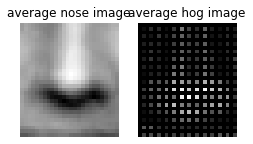

In [ ]:
nose_h = 30
nose_w = 26

nose_shape = (nose_h, nose_w)

avg_nose = get_detector(nose_h, nose_w, noses, image_paths)

(nose_feature, nose_hog) = hog_feature(avg_nose, pixel_per_cell=2)

plot_part4(avg_nose, nose_hog, 'nose')

Run through the following code to get a detector for mouth

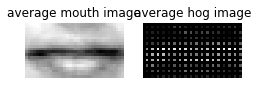

In [ ]:
mouth_h = 20
mouth_w = 36

mouth_shape = (mouth_h, mouth_w)

avg_mouth = get_detector(mouth_h, mouth_w, mouths, image_paths)

(mouth_feature, mouth_hog) = hog_feature(avg_mouth, pixel_per_cell=2)

detectors_list = [lefteye_feature, righteye_feature, nose_feature, mouth_feature]

plot_part4(avg_mouth, mouth_hog, 'mouth')

# Part 5: Human Parts Location (15points)

###  5.1 Compute displacement (10 points)

Implement **`compute_displacement`** to get an average shift vector mu and standard deviation sigma for each part of the face. The vector mu is the distance from the main center, i.e the center of the face, to the center of the part. <br>


In [ ]:
def compute_displacement(part_centers, face_shape):
    """ Calculate the mu and sigma for each part. d is the array
        where each row is the main center (face center) minus the
        part center. Since in our dataset, the face is the full
        image, face center could be computed by finding the center
        of the image. Vector mu is computed by taking an average from
        the rows of d. And sigma is the standard deviation among
        among the rows. Note that the heatmap pixels will be shifted
        by an int, so mu is an int vector.
    Args:
        part_centers: np array of shape (n,2) containing centers
            of one part in each image.
        face_shape: (h,w) that indicates the shape of a face.
    Returns:
        mu: (1,2) vector.
        sigma: (1,2) vector.
    """
    d = np.zeros((part_centers.shape[0],2))
    ### YOUR CODE HERE
    d = np.array([face_shape[0] / 2, face_shape[1] / 2]) - part_centers
    mu = d.mean(axis=0).astype(int)
    sigma = d.std(axis=0)
    ### END YOUR CODE
    return mu, sigma

In [ ]:
# test for compute_displacement
test_array = np.array([[0,1],[1,2],[2,3],[3,4]])
test_shape = (6,6)
mu, std = compute_displacement(test_array, test_shape)
assert(np.all(mu == [1,0]))
assert(np.sum(std-[ 1.11803399,  1.11803399])<1e-5)
print("Your implementation is correct!")

Your implementation is correct!


In [ ]:
lefteye_mu, lefteye_std = compute_displacement(lefteyes, face_shape)
righteye_mu, righteye_std = compute_displacement(righteyes, face_shape)
nose_mu, nose_std = compute_displacement(noses, face_shape)
mouth_mu, mouth_std = compute_displacement(mouths, face_shape)

After getting the shift vectors, we can run our detector on a test image. We will first run the following code to detect each part of left eye, right eye, nose and mouth in  the image. You will see a response map for each of them.

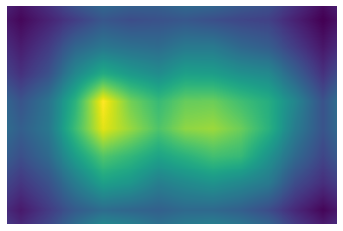

In [ ]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(face_H, face_W) = face_shape
max_score, face_r, face_c, face_scale, face_response_map = pyramid_score\
    (image, face_feature, face_shape,stepSize = 30, scale=0.8)

plot_part5_1(face_response_map)

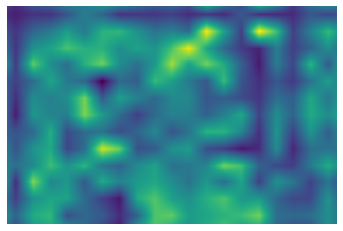

In [ ]:
max_score, lefteye_r, lefteye_c, lefteye_scale, lefteye_response_map = pyramid_score(image, lefteye_feature,lefteye_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

lefteye_response_map = resize(lefteye_response_map, face_response_map.shape)

plot_part5_1(lefteye_response_map)

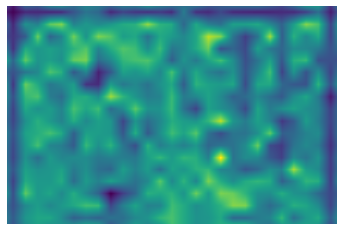

In [ ]:
max_score, righteye_r, righteye_c, righteye_scale, righteye_response_map = \
    pyramid_score (image, righteye_feature, righteye_shape, stepSize = 20,scale=0.9, pixel_per_cell=2)

righteye_response_map = resize(righteye_response_map, face_response_map.shape)

plot_part5_1(righteye_response_map)

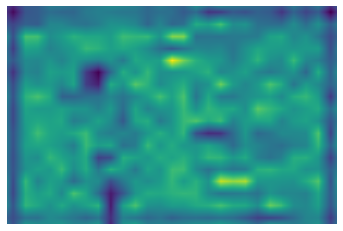

In [ ]:
max_score, nose_r, nose_c, nose_scale, nose_response_map = \
    pyramid_score (image, nose_feature, nose_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

nose_response_map = resize(nose_response_map, face_response_map.shape)

plot_part5_1(nose_response_map)

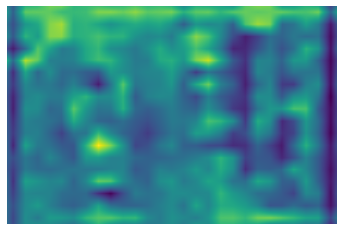

In [ ]:
max_score, mouth_r, mouth_c, mouth_scale, mouth_response_map =\
    pyramid_score (image, mouth_feature, mouth_shape, stepSize = 20,scale=0.9, pixel_per_cell = 2)

mouth_response_map = resize(mouth_response_map, face_response_map.shape)

plot_part5_1(mouth_response_map)

###  5.2 Shift heatmap (5 points)

After getting the response maps for each part of the face, we will shift these maps so that they all have the same center as the face. We have calculated the shift vector mu in `compute_displacement`, so we are shifting based on vector mu. Implement `shift_heatmap` function.

In [ ]:
def shift_heatmap(heatmap, mu):
    """First normalize the heatmap to make sure that all the values
        are not larger than 1.
        Then shift the heatmap based on the vector mu.
        Hint: use the interpolation.shift function provided by scipy.ndimage.
        Args:
            heatmap: np array of (h,w).
            mu: vector array of (1,2).
        Returns:
            new_heatmap: np array of (h,w).
    """
    ### YOUR CODE HERE
    pass
    ### END YOUR CODE
    return new_heatmap

In [ ]:
face_heatmap_shifted = shift_heatmap(face_response_map, [0,0])

lefteye_heatmap_shifted = shift_heatmap(lefteye_response_map, lefteye_mu)
righteye_heatmap_shifted = shift_heatmap(righteye_response_map, righteye_mu)
nose_heatmap_shifted = shift_heatmap(nose_response_map, nose_mu)
mouth_heatmap_shifted = shift_heatmap(mouth_response_map, mouth_mu)

plot_part5_2(lefteye_heatmap_shifted, righteye_heatmap_shifted,
                 nose_heatmap_shifted, mouth_heatmap_shifted)

# Part 6: Gaussian Filter (20 points)

## Part 6.1 Gaussian Filter
In this part, apply gaussian filter convolution to each heatmap. Blur by kernel of standard deviation sigma, and then add the heatmaps of the parts with the heatmap of the face. On the combined heatmap, find the maximum value and its location. You can use function provided by skimage to implement **`gaussian_heatmap`**.

In [ ]:
def gaussian_heatmap(heatmap_face, heatmaps, sigmas):
    """
    Apply gaussian filter with the given sigmas to the corresponding heatmap.
    Then add the filtered heatmaps together with the face heatmap.
    Find the index where the maximum value in the heatmap is found.
    Hint: use gaussian function provided by skimage.
    Args:
        image: np array of (h,w).
        sigma: sigma for the gaussian filter.
    Return:
        new_image: an image np array of (h,w) after gaussian convoluted.
    """
    ### YOUR CODE HERE
    pass
    ### END YOUR CODE
    return heatmap, r , c

In [ ]:
heatmap_face= face_heatmap_shifted

heatmaps = [lefteye_heatmap_shifted, 
           righteye_heatmap_shifted,
           nose_heatmap_shifted,
           mouth_heatmap_shifted]
sigmas = [lefteye_std, righteye_std, nose_std, mouth_std]

heatmap, i , j = gaussian_heatmap(heatmap_face, heatmaps, sigmas)
print(heatmap.shape, image.shape)
plot_part6_1(winH, winW, heatmap, image, i, j)

## 6.2 Result Analysis (10 points)

Does your DPM work on detecting human faces? Can you think of a case where DPM may work better than the detector we had in part 3 (sliding window + image pyramid)? You can also have examples that are not faces.

**Your Answer:** Write your answer in this markdown cell.